# Some exploratory data anaylisis, to check that the normalisation is working

In [43]:
from configs import avail_models, get_avail_splits
from models import norm_vals
from video_dataset import get_wlasl_info, get_data_set, DataSetInfo
import utils
import configs
import torch
from torch.utils.data import DataLoader

In [44]:
configs.set_seed()

## Setup

### Model

Available models:

In [45]:
av_models = avail_models()
for idx, m in enumerate(av_models):
    print(f"{idx}: {m}")

0: S3D
1: R3D_18
2: R(2+1)D_18
3: Swin3D_T
4: Swin3D_S
5: Swin3D_B
6: MViTv2_S
7: MViTv1_B


Chosen model: 

In [46]:
model_name = av_models[7]
print(model_name)

MViTv1_B


Norm values: 

In [47]:
model_info = norm_vals(model_name)
print(model_info)

{'mean': (0.45, 0.45, 0.45), 'std': (0.225, 0.225, 0.225)}


### Dataset

Available splits

In [48]:
av_splits = get_avail_splits()
for s in av_splits:
    print(s)

asl100
asl2000
asl300
asl1000


Chosen split, and set

In [49]:
split_name = av_splits[0]
print(split_name)

asl100


Dataset info

In [50]:
train_info = get_wlasl_info(split_name, set_name="train")
print(train_info)


{'root': PosixPath('../data/WLASL/WLASL2000'), 'labels': PosixPath('preprocessed/labels/asl100'), 'label_suff': 'fixed_frange_bboxes_len.json', 'set_name': 'train'}


Class list

In [51]:
class_list = configs.get_class_list()
print(len(class_list))

2000


#### Data Sets

one in regular conditions, and the other 'raw'


In [52]:
model_info = norm_vals(model_name)
print(model_info)
num_frames = 16
frame_size = 112
batch_size = 1

{'mean': (0.45, 0.45, 0.45), 'std': (0.225, 0.225, 0.225)}


In [53]:
print(model_info)

{'mean': (0.45, 0.45, 0.45), 'std': (0.225, 0.225, 0.225)}


In [54]:
train_set, num_classes, _, _ = get_data_set(
    set_info=train_info,
    norm_dict=model_info,
    num_frames=num_frames,
    frame_size=frame_size,
    resize_by_diagonal=True #NOTE might be useful actually
    
)

test_set, num_classes, _, _ = get_data_set(
    set_info=train_info,
    norm_dict=model_info,
    frame_size=frame_size,
    num_frames=num_frames,
    cropping='Centre' #use the training set data, but with a centre crop
)

raw_set, _, _, _ = get_data_set(
    set_info=train_info,
    norm_dict=None,
    num_frames=None,
    frame_size=None,
    cropping='Bbox'
    )

In [55]:
train_loader = DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=False, #not that consistent with training, but useful for eda
    num_workers=0,
    pin_memory=False,
)

test_loader = DataLoader(
    test_set, 
    batch_size=1,
    shuffle=False,
    num_workers=0,
    pin_memory=False
)

raw_loader = DataLoader(
    raw_set,
    shuffle=False,
    num_workers=0,
    pin_memory=False,
)

In [56]:
print(len(train_loader))
print(num_classes)

1442
100


## Examine frames

In [57]:
iter_train_loader = iter(train_loader)
iter_test_loader = iter(test_loader)
iter_raw_loader = iter(raw_loader)

In [58]:
sample_train = next(iter_train_loader)
sample_test = next(iter_test_loader)
sample_raw = next(iter_raw_loader)


In [59]:
rf = sample_raw['frames']
print(rf.shape)

torch.Size([1, 3, 63, 232, 147])


In [60]:
def prep_next2(sample: dict[str, int | torch.Tensor]) -> tuple[torch.Tensor, int]:
    frames = sample['frames']
    assert isinstance(frames, torch.Tensor), f'frames is type: {type(frames)}'
    label_num = sample['label_num']
    assert isinstance(label_num, torch.Tensor), f'label num is type: {type(label_num)}'
    
    if len(frames.shape) == 5:
        frames = frames.squeeze(dim=0)
    if frames.shape[1] != 3: 
        frames = frames.permute(1, 0, 2, 3) #swap T and C
    return frames, int(label_num.squeeze())

# Looking at what the machine sees 
## (training)

frames: torch.Size([16, 3, 112, 112])
Class: book


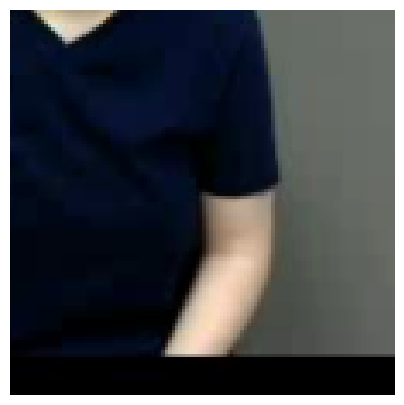

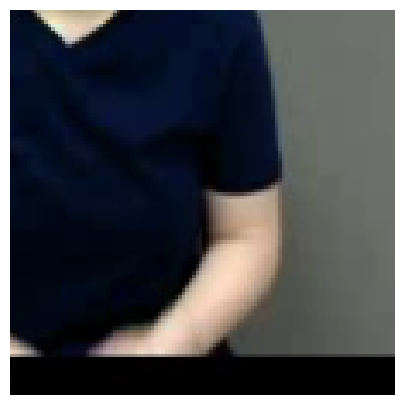

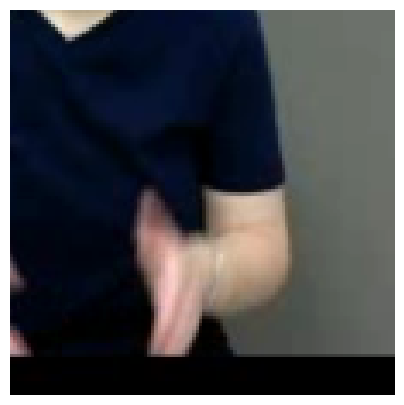

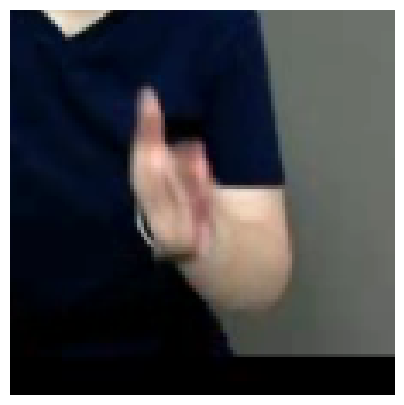

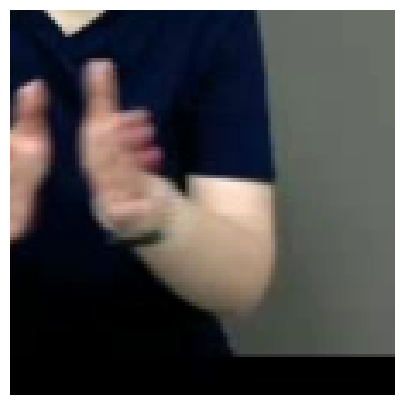

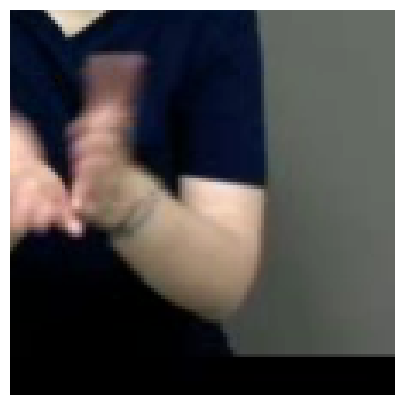

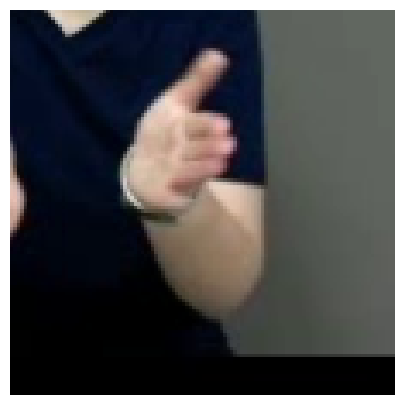

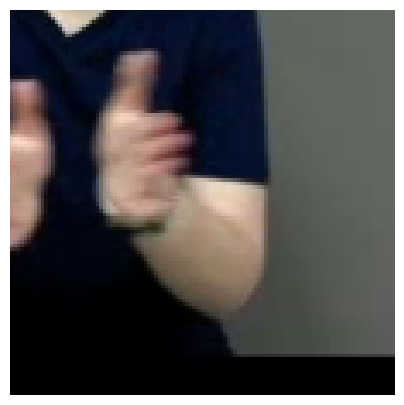

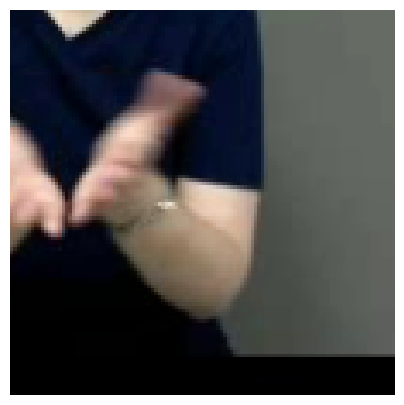

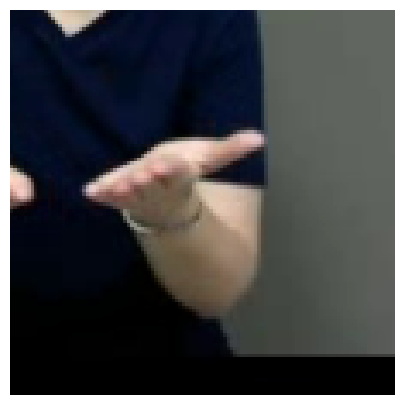

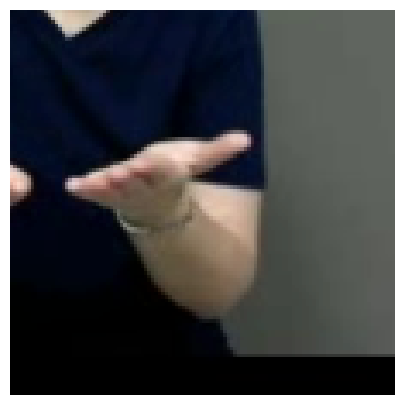

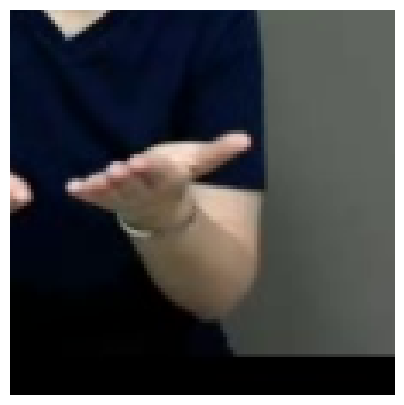

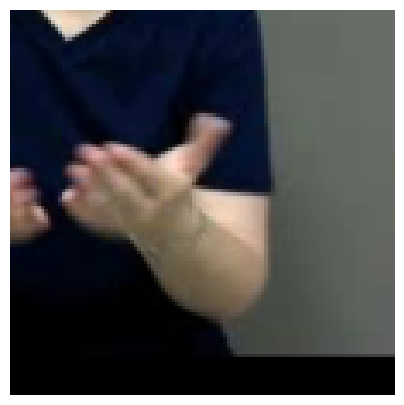

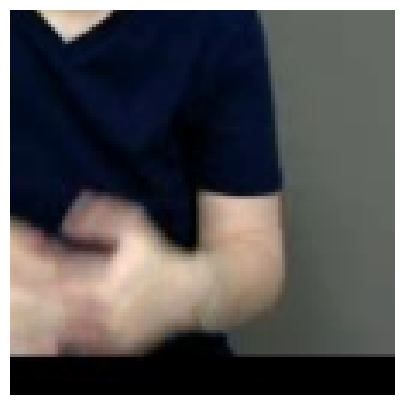

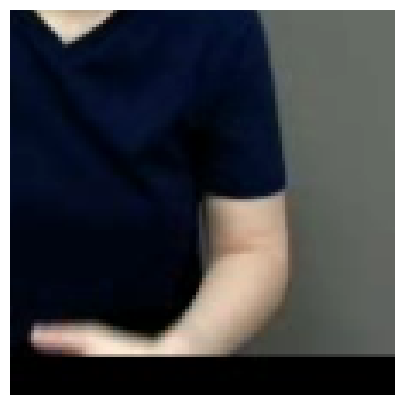

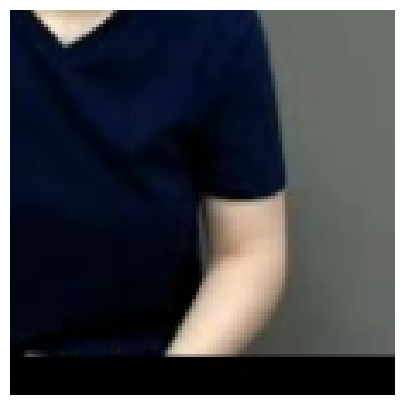

In [61]:
frames_train, label_num = prep_next2(sample_train)
print(f"frames: {frames_train.shape}")
print(f'Class: {class_list[label_num]}')
utils.plt_display(frames_train, num_frames)

## Testing

frames: torch.Size([16, 3, 112, 112])
Class: book


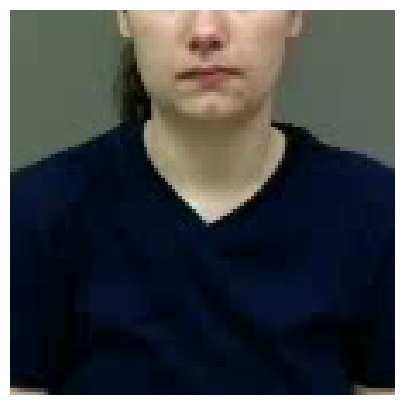

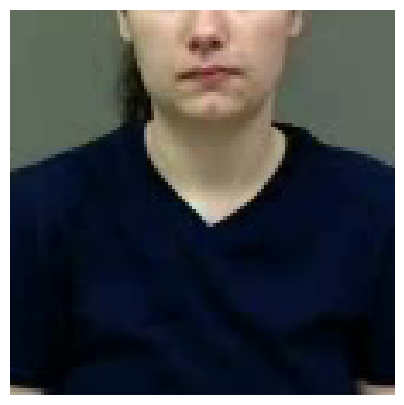

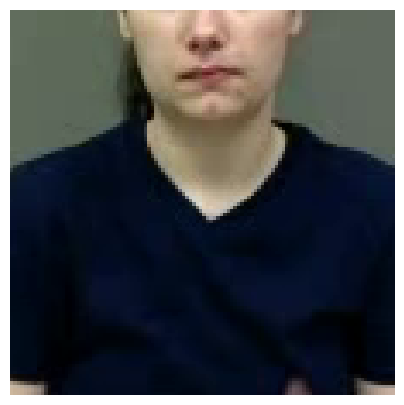

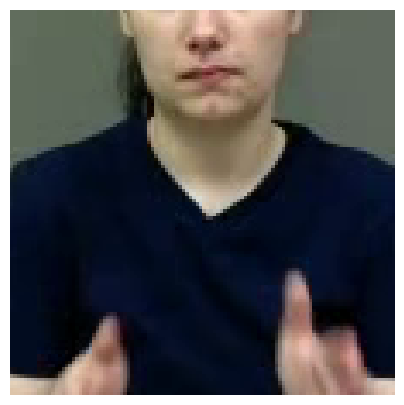

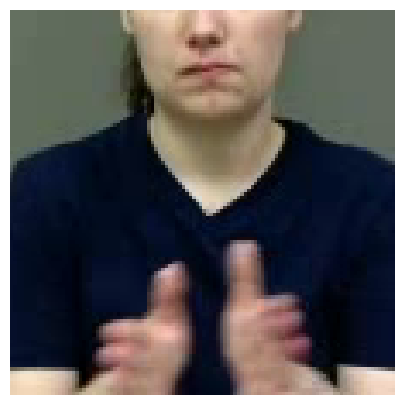

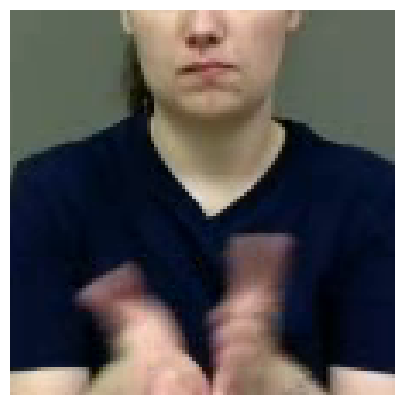

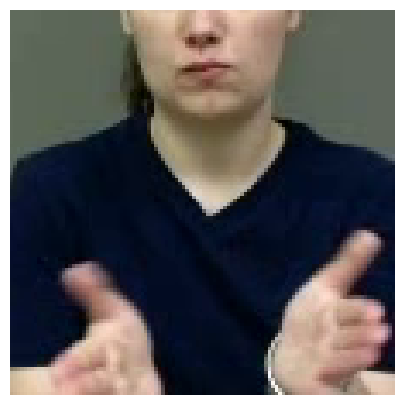

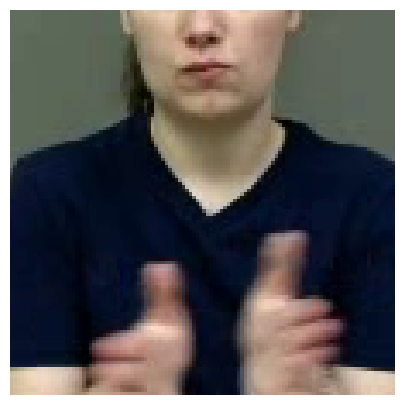

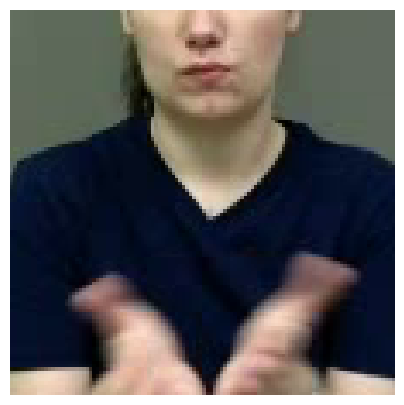

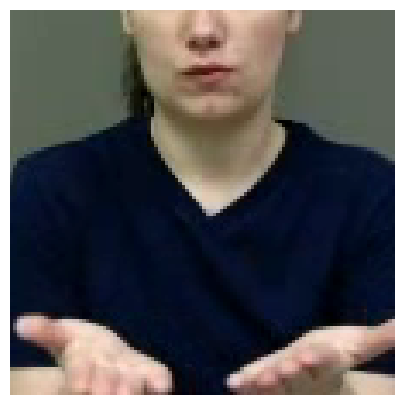

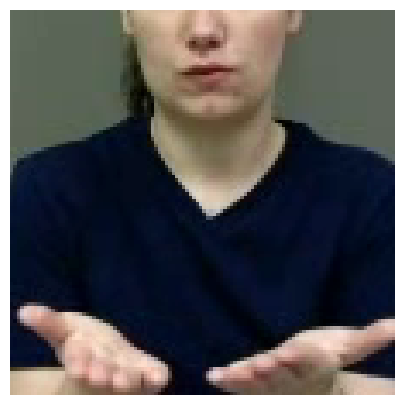

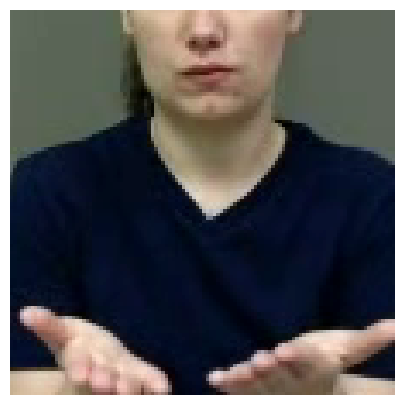

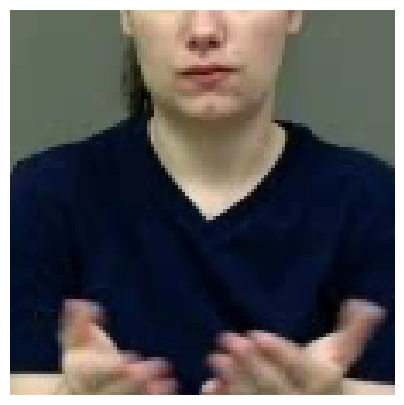

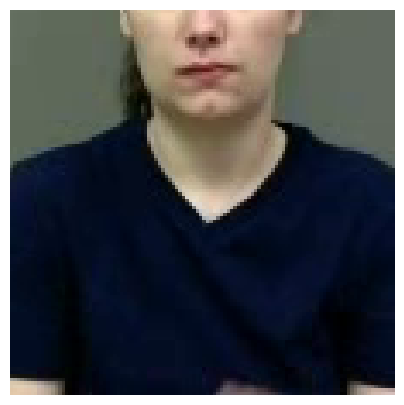

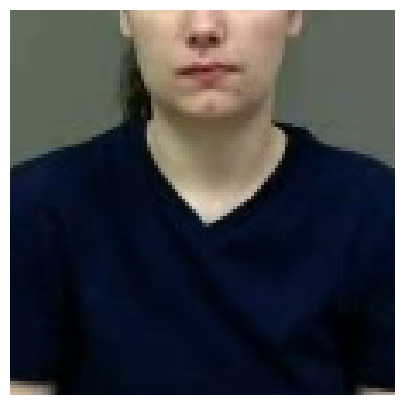

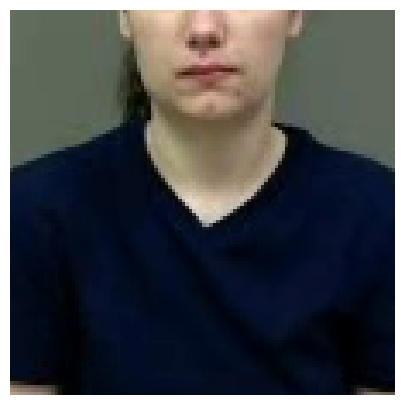

In [62]:
frames_test, label_num = prep_next2(sample_test)
print(f"frames: {frames_test.shape}")
print(f'Class: {class_list[label_num]}')
utils.plt_display(frames_test, num_frames)

## Looking at the actual video

frames: torch.Size([63, 3, 232, 147])
Class: book


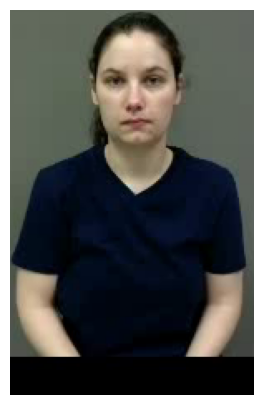

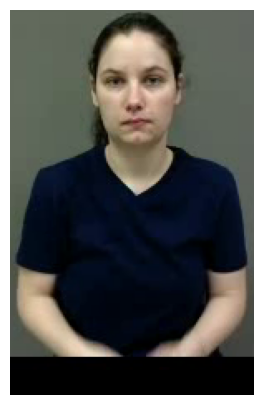

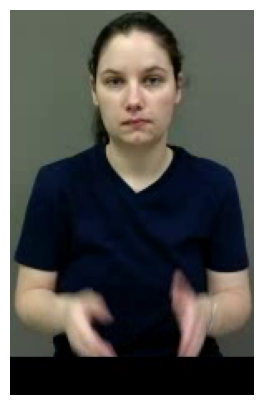

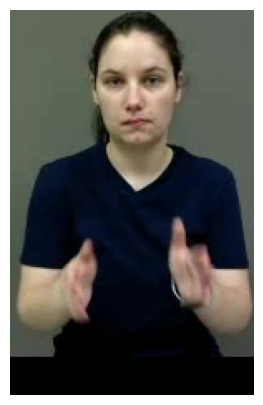

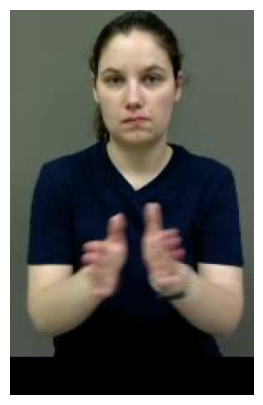

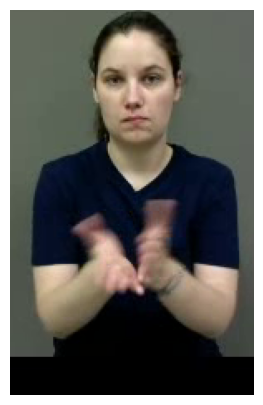

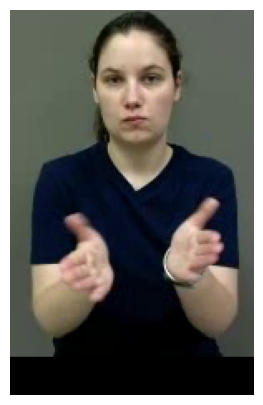

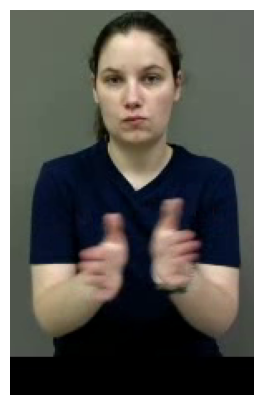

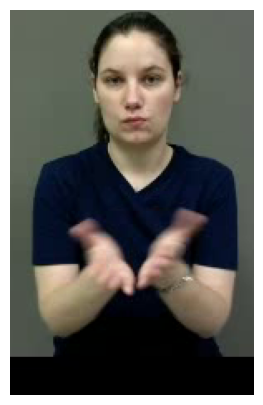

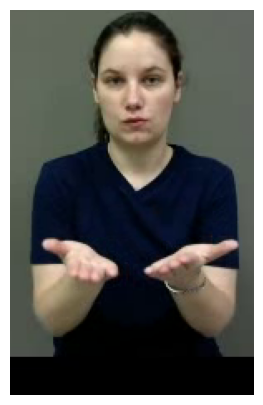

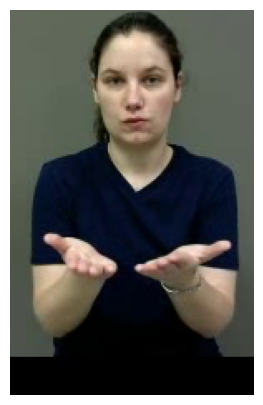

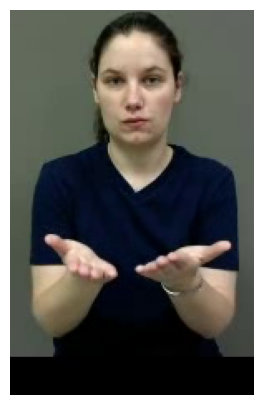

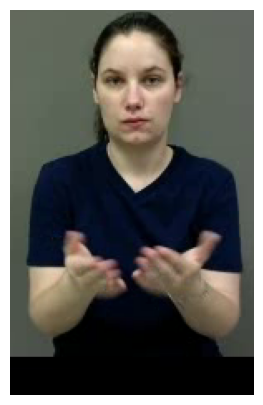

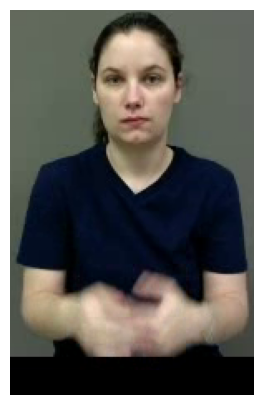

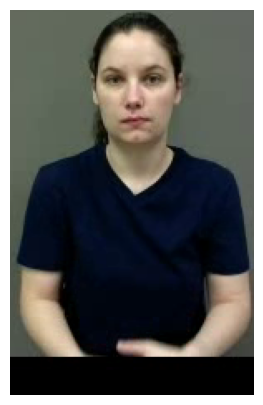

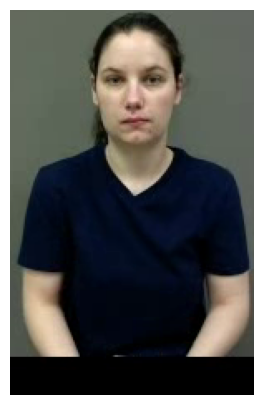

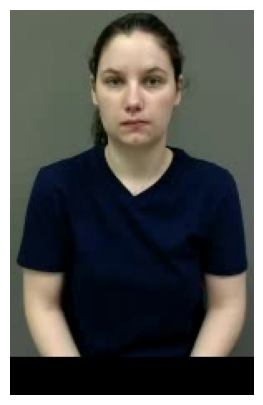

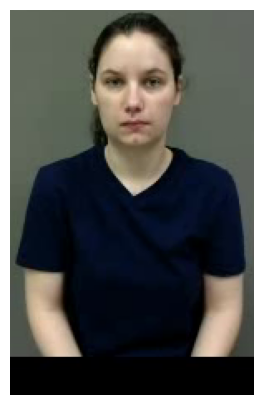

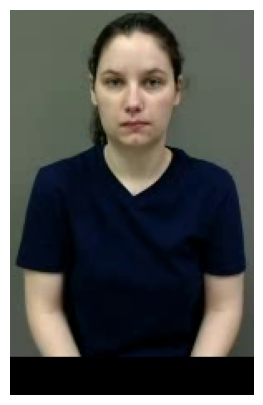

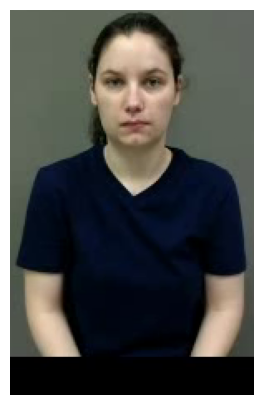

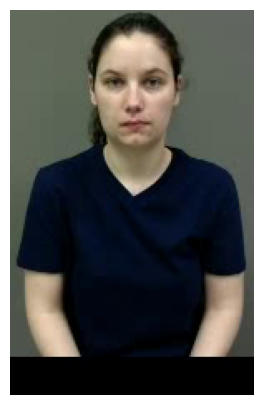

In [63]:
frames_raw, label_num = prep_next2(sample_raw)
print(f"frames: {frames_raw.shape}")
print(f'Class: {class_list[label_num]}')
utils.plt_display(frames_raw, num_frames)

# Conclusion:

It seems that during training, significant amounts of information are being lost during cropping. Perhaps this can be remidied. Additionally, perhaps it is worth while testing with crop_bbox, instead of centre crop. 